In [2]:
import datetime
import yfinance as yf
import statsmodels.tsa.stattools as sm
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/michael_melnikov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
stock = 'aapl'
train_start = '2020-01-01'
train_end = pd.Timestamp('2023-10-31', tz='America/New_York')
sim_start = '2023-10-30'
sim_end = pd.Timestamp('2023-12-31', tz='America/New_York')
scen_size = 10000

In [7]:
ticker = yf.Ticker('aapl')

In [8]:
train_set = ticker.history(start=train_start, end=train_end)['Close']

In [9]:
test_set = ticker.history(start=sim_start, end=sim_end)['Close']

In [10]:
s0 = train_set.iloc[-1]
dt = 1

In [11]:
test_set

Date
2023-10-30 00:00:00-04:00    169.619125
2023-10-31 00:00:00-04:00    170.097260
2023-11-01 00:00:00-04:00    173.284653
2023-11-02 00:00:00-04:00    176.870483
2023-11-03 00:00:00-04:00    175.954086
2023-11-06 00:00:00-05:00    178.523941
2023-11-07 00:00:00-05:00    181.103729
2023-11-08 00:00:00-05:00    182.169510
2023-11-09 00:00:00-05:00    181.691406
2023-11-10 00:00:00-05:00    185.910278
2023-11-13 00:00:00-05:00    184.314484
2023-11-14 00:00:00-05:00    186.947556
2023-11-15 00:00:00-05:00    187.516052
2023-11-16 00:00:00-05:00    189.211609
2023-11-17 00:00:00-05:00    189.191650
2023-11-20 00:00:00-05:00    190.947021
2023-11-21 00:00:00-05:00    190.139145
2023-11-22 00:00:00-05:00    190.807404
2023-11-24 00:00:00-05:00    189.470901
2023-11-27 00:00:00-05:00    189.291367
2023-11-28 00:00:00-05:00    189.899765
2023-11-29 00:00:00-05:00    188.872482
2023-11-30 00:00:00-05:00    189.450958
2023-12-01 00:00:00-05:00    190.737579
2023-12-04 00:00:00-05:00    188.93

In [12]:
train_set

Date
2020-01-02 00:00:00-05:00     72.960464
2020-01-03 00:00:00-05:00     72.251137
2020-01-06 00:00:00-05:00     72.826851
2020-01-07 00:00:00-05:00     72.484337
2020-01-08 00:00:00-05:00     73.650337
                                ...    
2023-10-24 00:00:00-04:00    172.756744
2023-10-25 00:00:00-04:00    170.425964
2023-10-26 00:00:00-04:00    166.232529
2023-10-27 00:00:00-04:00    167.557297
2023-10-30 00:00:00-04:00    169.619141
Name: Close, Length: 964, dtype: float64

In [13]:
n_of_wkdays = pd.date_range(start=pd.to_datetime(train_end,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(sim_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays

In [14]:
N = T / dt
t = np.arange(1, N + 1)

In [15]:
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
mu = daily_returns.mean()

In [16]:
sigma = np.std(daily_returns)

In [17]:
b = {str(scen): np.random.normal(0,1, int(N)) for scen in range(1, scen_size + 1)}

In [19]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [20]:
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [36]:
drift

array([0.00087629, 0.00175257, 0.00262886, 0.00350515, 0.00438143,
       0.00525772, 0.00613401, 0.00701029, 0.00788658, 0.00876287,
       0.00963915, 0.01051544, 0.01139172, 0.01226801, 0.0131443 ,
       0.01402058, 0.01489687, 0.01577316, 0.01664944, 0.01752573,
       0.01840202, 0.0192783 , 0.02015459, 0.02103088, 0.02190716,
       0.02278345, 0.02365974, 0.02453602, 0.02541231, 0.0262886 ,
       0.02716488, 0.02804117, 0.02891746, 0.02979374, 0.03067003,
       0.03154632, 0.0324226 , 0.03329889, 0.03417517, 0.03505146,
       0.03592775, 0.03680403, 0.03768032])

In [33]:
S = np.array([s0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[s0] for scen in range(1, scen_size + 1)]), S))

In [38]:
S[2]

array([169.61914062, 170.40902981, 176.00566629, 176.13220499,
       180.20349254, 176.80257776, 177.07056783, 175.70266529,
       173.56070026, 172.73642343, 174.32576827, 177.50033958,
       175.63496994, 180.54311695, 181.64447265, 184.73998703,
       188.61924884, 195.75386162, 189.58747394, 188.31148635,
       187.32839688, 188.23320718, 191.65670394, 189.66285604,
       189.53230419, 191.45219878, 191.08583465, 192.23050114,
       196.32349574, 193.5507116 , 188.15952391, 187.94476395,
       185.09062971, 186.23535523, 186.02539204, 182.56381839,
       186.28248011, 188.8678372 , 185.61658474, 178.16738941,
       185.709289  , 182.91611912, 183.6646355 , 176.74815612])

In [22]:
p = len(pd.date_range(start=train_set.index[-1],
                           end=sim_end,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna())

In [23]:
len(S[0])

44

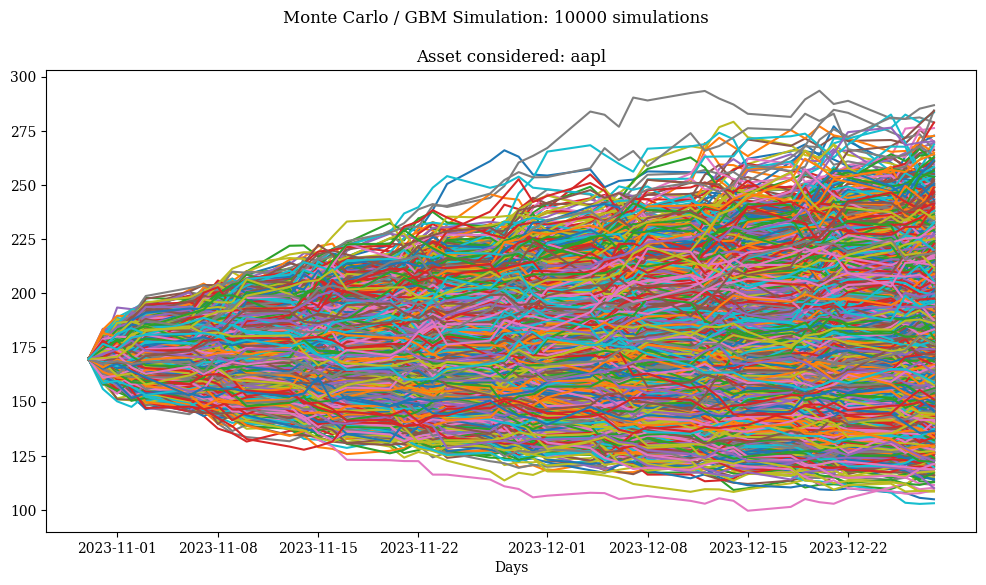

In [24]:
#fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(12,6))
plt.suptitle('Monte Carlo / GBM Simulation: ' +  str(scen_size) + ' simulations')
plt.title('Asset considered: ' + stock)
plt.xlabel('Days')


for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=sim_end,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna()[:p-1], S[i])

plt.show()

In [25]:
S_max = [S[:,i].max() for i in range(int(N))]
S_min = [S[:,i].min() for i in range(int(N))]
S_avg = 0.5 * np.array(S_max) + 0.5 *  np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_avg],
                              index=['real', 'pred']).T
final_df.index = test_set.index

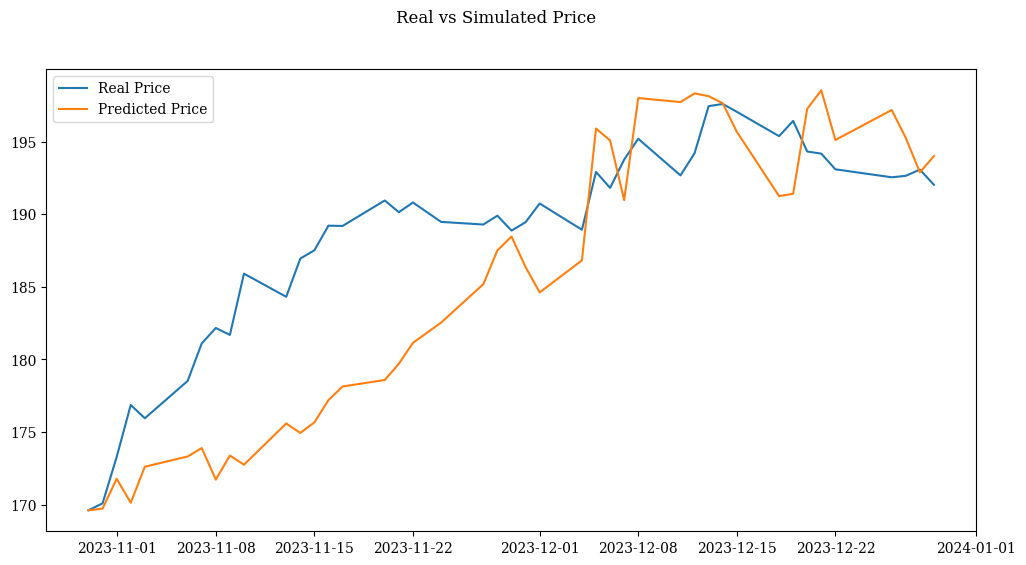

In [26]:
plt.figure(figsize=(12,6))
plt.suptitle('Real vs Simulated Price')
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'])
plt.show()